# <span style="color:red"> Logistic Regression - Top Prediction Analysis </span>

* Visualise the most important features for the Logistic Regression model 
* Analyse the most confidently predicted chunks of text for each translator

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))


# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [3]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [4]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(5212, 142)

### Load the Finalised Logistic Regression Model

In [6]:
in_full_path = '../../../../Documents/murakami/pkl_models/lreg_gs_05_drop_features.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    model = pickle.load(fp)

In [7]:
lr = Modelling(df, model)

In [8]:
# select feature groups for modelling
predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm',
                'he_w', 'had_w']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

### Plot the most important features for predicting each translator

In [9]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.best_estimator_.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2'])
# remove n_ and _norm to make plots easier to read
df_coef.columns = [col.replace('_norm', '') for col in df_coef.columns ]
df_coef.columns = [col[2:] if col[:2] == 'n_' else col for col in df_coef.columns ]
# transpose to have columns as indices
df_coef = df_coef.T

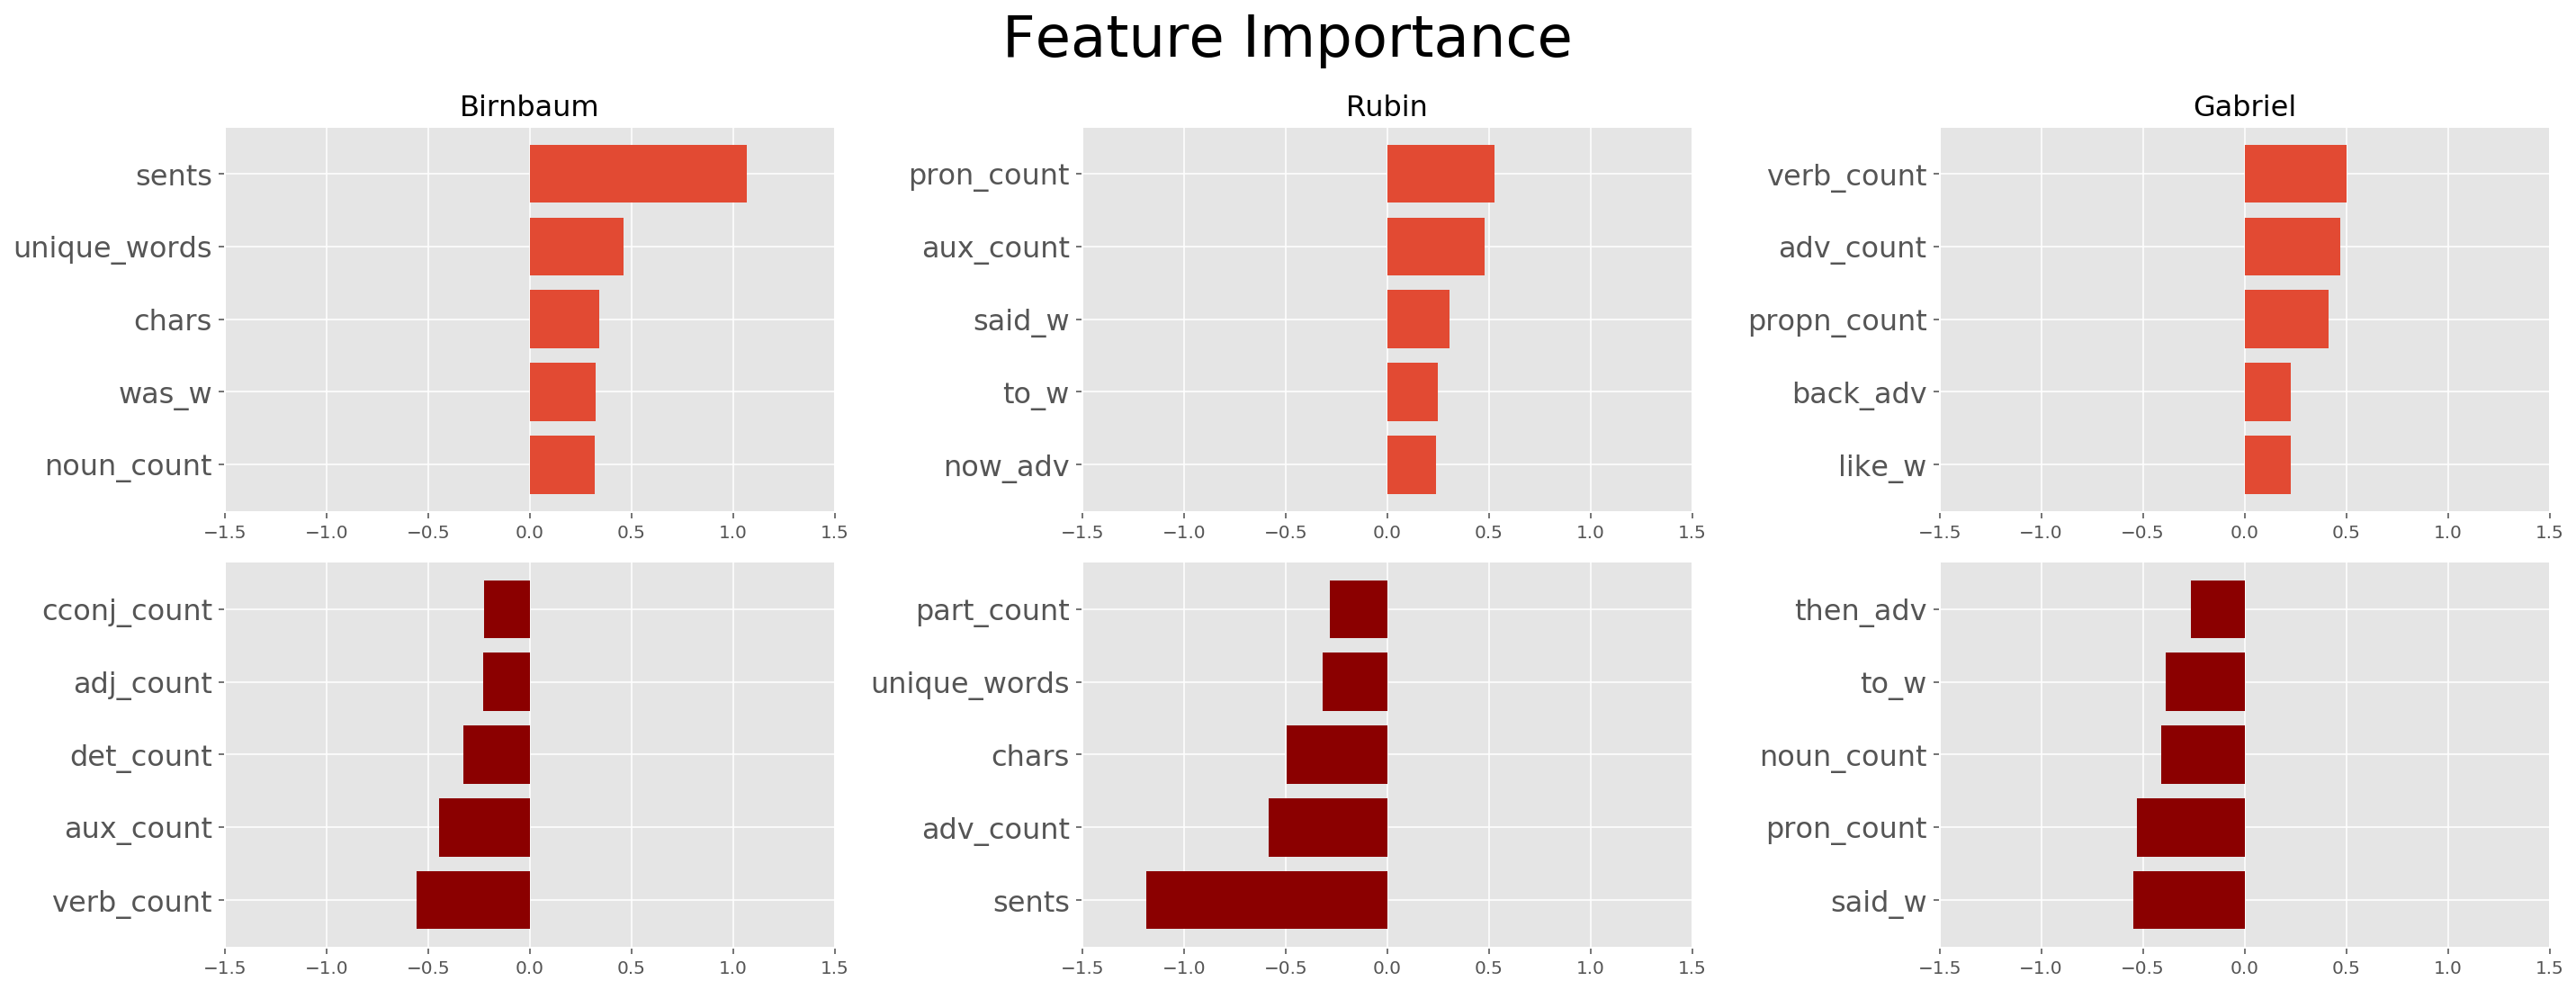

In [10]:
plt.style.use('ggplot')

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(20, 8))
fig.suptitle('Feature Importance', fontsize=32)


for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i], width=0.8)
    ax[0,i].set_title(str(col), fontsize=18)
    ax[0,i].set_xlim(-1.5, 1.5)
    ax[0,i].tick_params(axis='y', labelsize=16)


    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i], color='darkred', width=0.8)
    ax[1,i].set_xlim(-1.5, 1.5)
    ax[1,i].tick_params(axis='y', labelsize=16)

#     ax[1,i].xticks(fontsize=14)

ax[0,0].set_title('Birnbaum', fontsize=16)
ax[0,1].set_title('Rubin', fontsize=16)
ax[0,2].set_title('Gabriel', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
# plt.tight_layout()


# fig.suptitle('Largest Coefficient per Translator', fontsize=32, y=1.05)

plt.savefig('../../../../Documents/murakami/plots/top_lreg_coeffs_02.png')

plt.show()

### Review most confidently predicted texts per translator

In [11]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(model.best_estimator_.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = idx_test
Y_pp.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index
0,0.572411,0.221860,0.205729,4088
1,0.034092,0.706587,0.259321,2396
2,0.138053,0.773830,0.088116,4107
3,0.087154,0.179921,0.732925,3309
4,0.752105,0.099214,0.148680,4719


In [12]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)

In [13]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(3)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
538,0.918820,0.061444,0.019735,"“This job here today’s my last,” I said. “If I...",Alfred Birnbaum,The Elephant Vanishes,453,12
1029,0.906892,0.033392,0.059716,Huge enough to stop the middle-aged man’s sno...,Alfred Birnbaum,A Wild Sheep Chase,241,25
723,0.900403,0.025919,0.073678,I had plenty of run-ins with cops when I was i...,Philip Gabriel,Kafka On The Shore,679,36


In [14]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(3)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
481,0.011126,0.964391,0.024483,Just imagine if you will: for twenty-six year...,Jay Rubin,The Wind Up Bird Chronicle,654,14
291,0.056122,0.930861,0.013018,She hasn’t been in touch with you because she...,Jay Rubin,The Wind Up Bird Chronicle,437,3
835,0.048471,0.926813,0.024716,Kumiko’s parents were not above interpreting ...,Jay Rubin,The Wind Up Bird Chronicle,691,1


In [15]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(3)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
820,0.091372,0.025031,0.883597,The young man had to drive his truck over to ...,Philip Gabriel,Kafka On The Shore,425,22
17,0.089319,0.058144,0.852537,You could make a lot of money doing this.You c...,Philip Gabriel,Kafka On The Shore,482,24
124,0.075678,0.072602,0.851720,He wasn’t the type of pretty young boy who im...,Philip Gabriel,Colorless Tsukuru Tazaki,72,4


## Most confident for translator 0: 

In [16]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

'“This job here today’s my last,” I said. “If I don’t get myself back on the ball with my studies, my grade point average is going to be in real trouble.” The woman looked me hard in the face, then glanced at my feet, then looked back at my face. “A student, eh?” “Yeah,” I said. “What school?” The name of the university made no visible impression on her. It wasn’t a very impressive university. She just scratched behind her ear with her index finger. “So you’re giving up this line of work, then?” “Yeah, for this summer at least,” I said. No more mowing lawns for me this summer. Nor next summer, nor the next. The woman filled her cheeks with vodka tonic as if she were going to gargle, then gulped down her precious mouthwash half a swallow at a time. Her whole forehead beaded up with sweat, like it was crawling with tiny bugs. “Come inside,” the woman said. “It’s too hot outdoors.” I looked at my watch. Two thirty-five. Getting late? Still early? I couldn’t make up my mind. I’d already fi

## Most confident for translator 1

In [17]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

' Just imagine if you will: for twenty-six years, I was nothing. This is the thought that struck me with such force when I was alone in the well, thinking. During all this long time, the person called ‘me’ was in fact nothing at all, I realized. I was nothing but a prostitute. A prostitute of the flesh. A prostitute of the mind. “Now, however, I am trying to get a grasp on my new self. I am neither a container nor a medium. I am trying to establish myself here on the face of the earth.” “I understand what you are saying to me, but still, why do you want to go to Crete with me ?” “Because it could be a good thing for both of us: for you, Mr Okada, and for me,” said Creta Kano. “For the time being, there is no need for either of us to be here. And if that is the case, I feel, it would be better for us not to be here. Tell me, Mr Okada, do you have some course of action you must follow – some plan for what you are going to do from this point on?” “The one thing I need to do is talk to Kum

## Most confident for translator 2

In [18]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

' The young man had to drive his truck over to the warehouse to deliver his load of furniture, so he told Nakata to wait for him at a small park near the harbor. "Don’t move from here, okay?" Hoshino cautioned him. "There’s a restroom over there, and a water fountain. You got everything you need. If you wander off somewhere, you might not find your way back." "I understand. I’m not in Nakano Ward anymore." "Exactly. This isn’t Nakano. So sit tight, and I’ll be back real soon." "All right. I’ll stay right here." "Good. I’ll be back as soon as I finish my delivery." Nakata did as he was told, not moving from the bench, not even to use the restroom. He didn’t find staying put in one place for a long time very hard. Sitting still, in fact, was his specialty. He could see the sea from where he sat. This he hadn’t seen for a long, long time. When he was little, he and his family had gone to the seaside any number of times. He’d put on trunks, splash around on the shore, gather seashells at l

## Look at key predictor values for most confident results

In [19]:
# need to update this with the correct indices if any changes in modelling
top_predictions = Y_pp_merged[Y_pp_merged.index.isin([538,481,820])]
top_predictions

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,then_adv,more_adv,even_adv,why_adv,maybe_adv,again_adv,now_adv,just_adv,how_adv,where_adv,very_adv,only_adv,there_adv,still_adv,so_adv,too_adv,when_adv,all_adv,here_adv,never_adv,as_adv,new_adj,other_adj,more_adj,small_adj,deep_adj,whole_adj,first_adj,bad_adj,little_adj,next_adj,much_adj,own_adj,hard_adj,last_adj,only_adj,big_adj,right_adj,long_adj,old_adj,strange_adj,same_adj,young_adj,sure_adj,able_adj,real_adj,different_adj,good_adj,few_adj,vlong_words_count
481,0.011126,0.964391,0.024483,3069,654,14,Creta Kano’s New Departure \n •,CRETA KANO WENT on with her story. \n “For so...,"[34, 119, 183, 239, 388, 467, 564, 624, 699, 8...","[997, 1987, 2848, 3997, 4905, 5973, 6935, 7911...",Just imagine if you will: for twenty-six year...,Jay Rubin,The Wind Up Bird Chronicle,"( , Just, imagine, if, you, will, :, for, twen...",16,209,747,250,110,16,176,8,1,1003,15.952144,208.374875,744.765703,249.252243,109.670987,15.952144,175.473579,7.976072,0.7399,0.026,0.923,0.050,35.0,23.0,29.0,6.0,3.0,46.0,27.0,26.0,5.0,4.0,11.0,24.0,8.0,8.0,...,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
538,0.918820,0.061444,0.019735,2331,453,12,12,I MUST HAVE been eighteen or nineteen when I m...,"[94, 111, 182, 425, 495, 517, 553, 612, 632, 6...","[968, 1923, 2976, 3966, 4955, 5893, 6943, 7934...","“This job here today’s my last,” I said. “If I...",Alfred Birnbaum,The Elephant Vanishes,"(“, This, job, here, today, ’s, my, last, ,, ”...",23,198,779,247,121,20,157,6,0,1023,22.482893,193.548387,761.485826,241.446725,118.279570,19.550342,153.470186,5.865103,0.8265,0.037,0.898,0.065,19.0,25.0,32.0,13.0,3.0,56.0,42.0,25.0,2.0,4.0,16.0,7.0,5.0,1.0,...,4,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
820,0.091372,0.025031,0.883597,896,425,22,\n Chapter 22,The truck Nakata was riding in arrived in Kobe...,"[77, 170, 242, 356, 457, 515, 584, 620, 691, 7...","[904, 1983, 2972, 3974, 4995, 5978, 6955, 7981...",The young man had to drive his truck over to ...,Philip Gabriel,Kafka On The Shore,"( , The, young, man, had, to, drive, his, truc...",22,202,768,240,121,19,172,8,2,1007,21.847071,200.595829,762.661370,238.331678,120.158888,18.867925,170.804369,7.944389,0.3197,0.019,0.950,0.031,23.0,36.0,22.0,9.0,1.0,47.0,27.0,20.0,3.0,4.0,26.0,12.0,12.0,7.0,...,0,0,1,0,0,0,0,0,0,1,1,0,1,1,2,0,1,1,2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,1,0,0


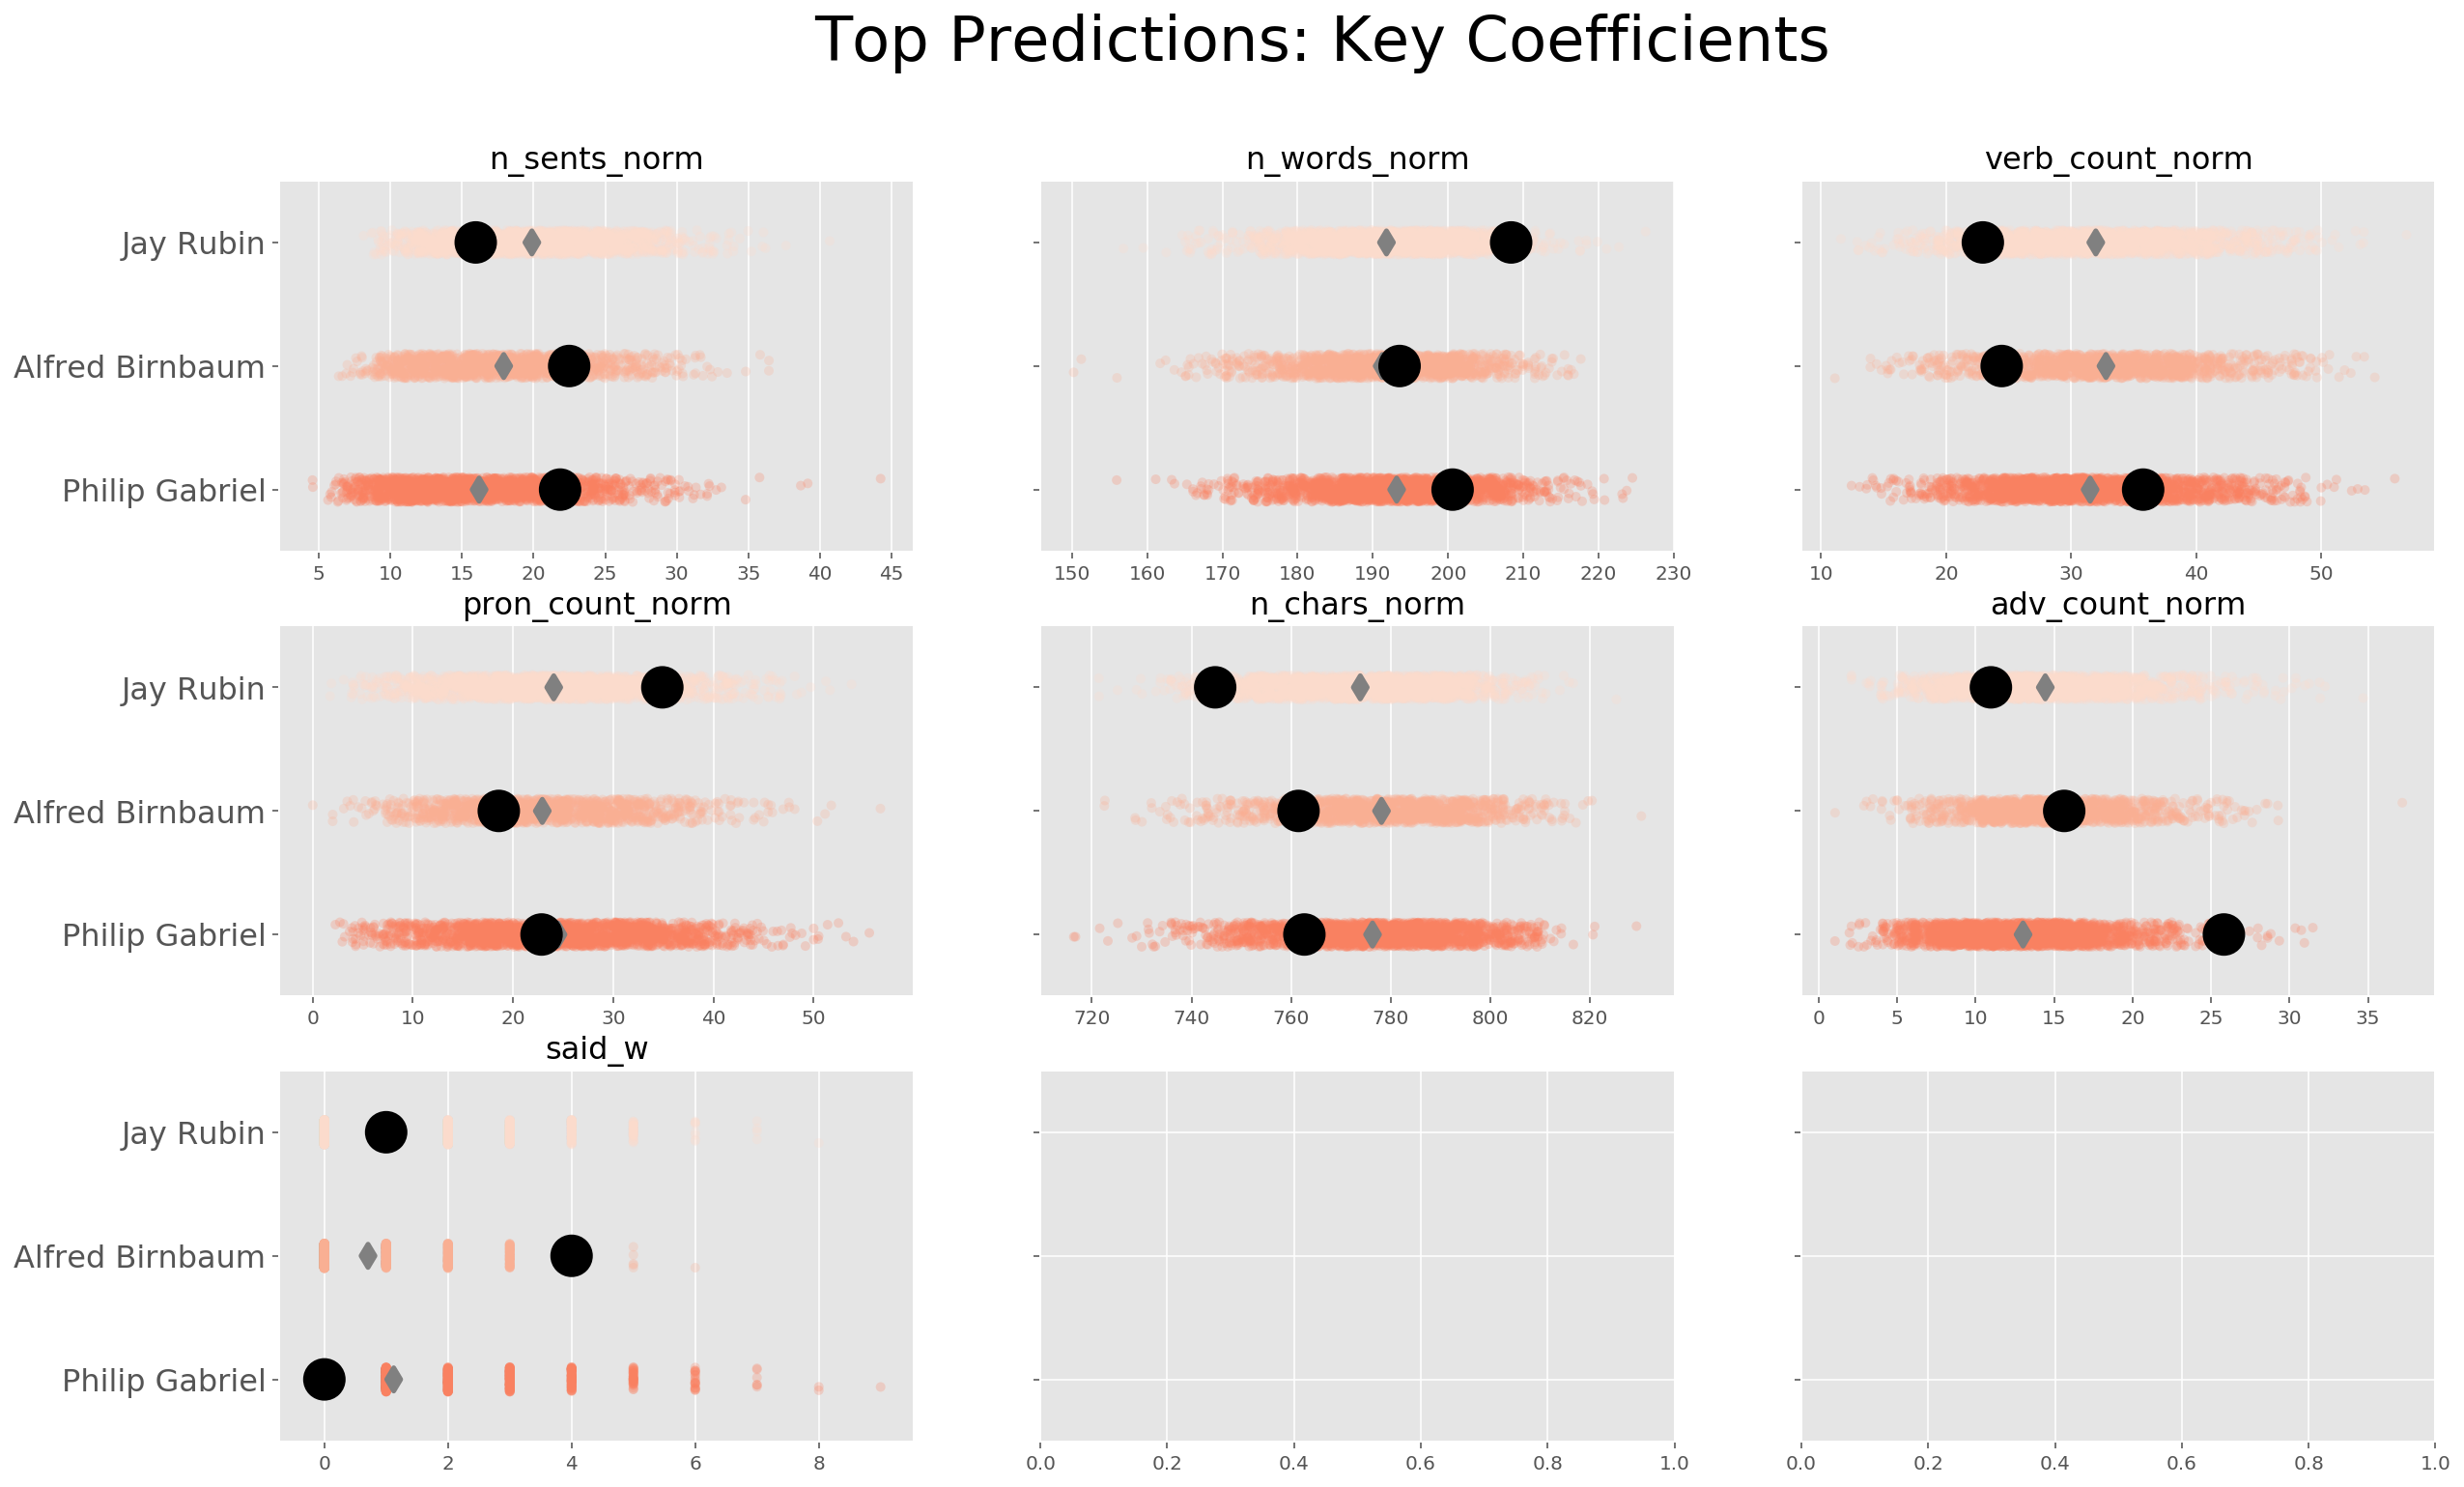

In [20]:
sns.set_palette("Reds")
preds2plot = ['n_sents_norm',
              'n_words_norm',
              'verb_count_norm',
              'pron_count_norm',
              'n_chars_norm',
              'adv_count_norm',
              'said_w']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 12), sharex=False, sharey=True)

for i in range(len(preds2plot)):
    sns.stripplot(x=preds2plot[i], y='translator',
                  data=df, dodge=True, alpha=.25, zorder=1, ax=ax[int(i/3),i%3])
    # Show the conditional means
    sns.pointplot(x=preds2plot[i], y='translator',
                  data=df, dodge=.532, join=False, color='grey',
                  markers="d", scale=1.25, ci=None, ax=ax[int(i/3),i%3])

    # Show the individual values for most confident predictions
    sns.pointplot(x=preds2plot[i], y="translator",
                  data=top_predictions, dodge=.532, join=False, color='black',
                  markers="o", scale=2.5, ci=None, ax=ax[int(i/3),i%3])
    fig.suptitle('Top Predictions: Key Coefficients', fontsize=32)
    ax[int(i/3),i%3].set_title(preds2plot[i], fontsize=16)
    ax[int(i/3),i%3].set_xlabel('')
    ax[int(i/3),i%3].set_ylabel('')
    ax[int(i/3),i%3].tick_params(axis="y", labelsize=16)
    
plt.savefig('../../../../Documents/murakami/plots/top_pred_key_coeffs_01.png')
# plt.subplots_adjust(hspace=0.6)
plt.show()

## Highlight words in the text to help visualise the features

In [21]:
# Colourise - colours text in shell. Returns plain if colour doesn't exist.
def colourise(colour, text):
    if colour == "black":
        return "\033[1;30m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;31m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;32m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;33m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;34m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;35m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;36m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;37m" + str(text) + "\033[1;m"
    return str(text)

# Highlight - highlights text in shell. Returns plain if colour doesn't exist.
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

# # Example usage:
# print(colourise("black", "Black"))
# print(highlight("red", "Highlight: red"))

# Example usage of colourise() + highlight()
# text = "Blue on red is difficult to read because the wavelengths are \
# refracted onto different areas of the eye."

# print(highlight("red", (colourise("blue", text))))

In [22]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    parsed = top_predictions['parsed'].iloc[i]
    verbs = [str(token) for token in parsed if token.pos_ == 'VERB' ]
    pronouns = [str(token) for token in parsed if token.pos_ == 'PRON' ]
    fin_list = []
    verb_count = 0
    pronoun_count = 0
    stop_count = 0
    for word in text.split():
        if word in verbs:
            fin_list.append(colourise("red", word))
            fin_list.append(' ')
            verb_count += 1
        elif word in pronouns:
            fin_list.append(colourise("magenta", word))
            fin_list.append(' ')
            pronoun_count += 1
        elif '.' in word or '?' in word:
            fin_list.append(word[:-1])
            fin_list.append(highlight("cyan", word[-1]))
            fin_list.append(' ')
            stop_count += 1
        else:
            fin_list.append(word)
            fin_list.append(' ')

    print('\n')
    print(top_predictions['translator'].iloc[i], '   ',
          colourise("red",'verbs'), verb_count, '   ', 
          colourise("magenta",'pronouns'), pronoun_count, '   ', 
          highlight("cyan",'stops'), stop_count,)
    print('\n')
    text1 = ''.join(fin_list)
    print(text1)
    



Jay Rubin     verbs 20     pronouns 27     stops 15


Just imagine if you will: for twenty-six years, I was nothing. This is the thought that struck me with such force when I was alone in the well, thinking. During all this long time, the person called ‘me’ was in fact nothing at all, I realized. I was nothing but a prostitute. A prostitute of the flesh. A prostitute of the mind. “Now, however, I am trying to get a grasp on my new self. I am neither a container nor a medium. I am trying to establish myself here on the face of the earth.” “I understand what you are saying to me, but still, why do you want to go to Crete with me ?” “Because it could be a good thing for both of us: for you, Mr Okada, and for me,” said Creta Kano. “For the time being, there is no need for either of us to be here. And if that is the case, I feel, it would be better for us not to be here. Tell me, Mr Okada, do you have some course of action you must follow – some plan for what you are going to do from this

In [23]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    parsed = top_predictions['parsed'].iloc[i]
    verbs = [str(token) for token in parsed if token.pos_ == 'VERB' ]
    pronouns = [str(token) for token in parsed if token.pos_ == 'PRON' ]
    fin_list = []
    had_count = 0
    he_count = 0
    for word in text.split():
        if word == 'had':
            fin_list.append(highlight("green", word))
            had_count += 1
        elif word == 'he':
            fin_list.append(highlight("yellow", word))
            he_count += 1
        else:
            fin_list.append(word)

    print('\n')
    print(top_predictions['translator'].iloc[i], '   ',
#     print(highlight("red",verb_count))
          highlight("green",'had'), had_count, '   ', 
          highlight("yellow",'he'), he_count,)
    print('\n')
    print(' '.join(fin_list))    



Jay Rubin     had 0     he 0


Just imagine if you will: for twenty-six years, I was nothing. This is the thought that struck me with such force when I was alone in the well, thinking. During all this long time, the person called ‘me’ was in fact nothing at all, I realized. I was nothing but a prostitute. A prostitute of the flesh. A prostitute of the mind. “Now, however, I am trying to get a grasp on my new self. I am neither a container nor a medium. I am trying to establish myself here on the face of the earth.” “I understand what you are saying to me, but still, why do you want to go to Crete with me ?” “Because it could be a good thing for both of us: for you, Mr Okada, and for me,” said Creta Kano. “For the time being, there is no need for either of us to be here. And if that is the case, I feel, it would be better for us not to be here. Tell me, Mr Okada, do you have some course of action you must follow – some plan for what you are going to do from this point on?” “The one th

## Highlight monosyllable words

In [24]:
re.sub(r'[\W_]+', '', 'text. ') 

'text'

In [25]:
# import
from nltk.corpus import cmudict
d = cmudict.dict()
def nsyl(word):
    return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]

In [26]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    fin_list = []
    mono_count = 0
    for word in text.split():
        try:
            word2 = re.sub(r'[\W_]+', '', word)
            syls = nsyl(word2)
            if syls[0] == 1:
                fin_list.append(colourise("red", word))
                mono_count += 1
            else:
                fin_list.append(word)        
        except:
            fin_list.append(word)
    print('\n')
    print(top_predictions['translator'].iloc[i], '   ',
          colourise("red",'monosyllable words'), mono_count)
    print('\n')
    print(' '.join(fin_list))  



Jay Rubin     monosyllable words 171


Just imagine if you will: for twenty-six years, I was nothing. This is the thought that struck me with such force when I was alone in the well, thinking. During all this long time, the person called ‘me’ was in fact nothing at all, I realized. I was nothing but a prostitute. A prostitute of the flesh. A prostitute of the mind. “Now, however, I am trying to get a grasp on my new self. I am neither a container nor a medium. I am trying to establish myself here on the face of the earth.” “I understand what you are saying to me, but still, why do you want to go to Crete with me ?” “Because it could be a good thing for both of us: for you, Mr Okada, and for me,” said Creta Kano. “For the time being, there is no need for either of us to be here. And if that is the case, I feel, it would be better for us not to be here. Tell me, Mr Okada, do you have some course of action you must follow – some plan for what you are going to do from this point on?” “Th